In [47]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision import transforms

import torch.nn as nn # torch.nn module, contains classes and functions to help build neural networks

import torch.optim as optim # provides various optimization algorithms, such as SGD (Stochastic Gradient Descent), Adam, etc
from torch.utils.data import DataLoader, TensorDataset # Dataloader - helps to load data, TensorDataset - allows to access data points as pairs(i/p, target)

from scipy.special import softmax
from sklearn.metrics import confusion_matrix, accuracy_score


# Downloading the MNIST digit datasets

In [48]:
# Ensuring one-hot format
def one_hot_encoder(x):
  temp_array = np.zeros(10, dtype=float) # numpy arrays of zeros with length 10, 0 through 9
  temp_array[x] = 1 # element at index x in the temp array set to 1
  return temp_array

# To normalize the input
def transform(x):
  return np.array(x)/255.0

In [49]:
train_data = datasets.MNIST(root='./data', train = True , download=True, transform=transform, target_transform = one_hot_encoder)
test_data = datasets.MNIST(root='./data', train = False ,download=True, transform=transform, target_transform = one_hot_encoder)


In [50]:
len(train_data)

60000

In [51]:
len(test_data)

10000

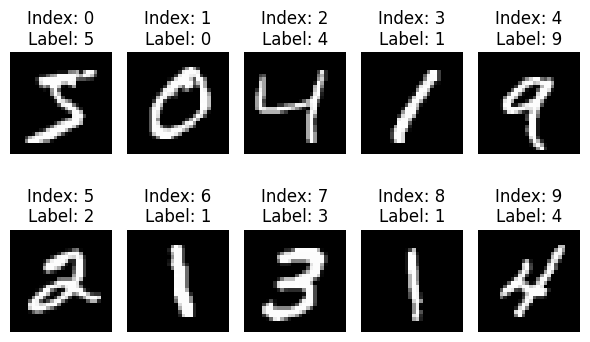

In [52]:
# Visualizing the data
fig, axes = plt.subplots(2, 5, figsize=(6, 4))  # 2 rows, 5 columns

for i in range(10):          # Loop through the first 10 images
  ax = axes[i // 5, i % 5]  # Determine the position of the subplot (row, column)

  ax.imshow(train_data.data[i], cmap='gray') # Display each image in grayscale
  ax.set_title(f"Index: {i}\nLabel: {train_data.targets[i].item()}")
  ax.axis('off')

plt.tight_layout() # Adjust layout to prevent overlap of titles
plt.show()

In [53]:
# organize the data in batches
# want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [54]:
len(train_dataloader)

938

In [55]:
len(test_dataloader)

157

# Code from scratch

In [56]:
input_layer = train_data.data[i].flatten().shape[0]
hidden1_layer = 500
hidden2_layer = 250
hidden3_layer = 100
out_layer = train_data.train_labels.unique().shape[0]

layers_dims = [input_layer, hidden1_layer, hidden2_layer, hidden3_layer, out_layer]


def initialize_parameters(layer_dimensions, initial):
  parameters = {}
  num_layers = len(layer_dimensions) # number of layers in the network

  for layer in range(1, num_layers):
    if initial == "glorot":
      M = np.sqrt(6*(1/(layer_dimensions[layer]+layer_dimensions[layer-1])))
      parameters['W' + str(layer)] = np.random.uniform(low = -M, high = M, size = (layer_dimensions[layer], layer_dimensions[layer-1]))
      parameters['b' + str(layer)] = np.zeros((layer_dimensions[layer], 1))

    elif initial == "random":
      parameters['W' + str(layer)] = np.random.randn(layer_dimensions[layer], layer_dimensions[layer-1]) / np.sqrt(layer_dimensions[layer-1])
      parameters['b' + str(layer)] = np.zeros((layer_dimensions[layer], 1))

    else:
      parameters['W' + str(layer)] = np.zeros((layer_dimensions[layer], layer_dimensions[layer-1]))
      parameters['b' + str(layer)] = np.zeros((layer_dimensions[layer], 1))

    assert(parameters['W' + str(layer)].shape == (layer_dimensions[layer], layer_dimensions[layer-1]))
    assert(parameters['b' + str(layer)].shape == (layer_dimensions[layer], 1))

  return parameters

#  Activation Function

In [57]:
# tanh activation function
def tanh(x):
  return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

def tanh_derivative(Z):
    """Compute the derivative of the tanh activation function."""
    return 1 - np.tanh(Z)**2

# Forward Propagation

In [58]:
def forward_propagation(input_data, parameters, activation_function):
    forward_propagation = {}
    num_layers = int(len(parameters) / 2)  # Total number of layers (excluding input)

    forward_propagation['Z1'] = np.dot(parameters['W1'], input_data) + parameters['b1'] # Linear transformation for the first layer

    for layer in range(2, num_layers): # Loop through layers 2 to (num_layers - 1) (hidden layers)
        # Activation from the previous layer
        forward_propagation['A' + str(layer - 1)] = activation_function(forward_propagation['Z' + str(layer - 1)])

        # Linear transformation for the current layer
        forward_propagation['Z' + str(layer)] = np.dot(parameters['W' + str(layer)], forward_propagation['A' + str(layer - 1)]) + parameters['b' + str(layer)]

    # Compute the final layer's activation
    forward_propagation['A' + str(num_layers - 1)] = activation_function(forward_propagation['Z' + str(num_layers - 1)])
    forward_propagation['Z' + str(num_layers)] = np.dot(parameters['W' + str(num_layers)], forward_propagation['A' + str(num_layers - 1)]) + parameters['b' + str(num_layers)]

    # Output layer: apply softmax
    forward_propagation['A' + str(num_layers)] = softmax(forward_propagation['Z' + str(num_layers)], axis=0)

    # Store forward pass results and parameters for backpropagation
    cache = (forward_propagation, parameters)

    return forward_propagation['A' + str(num_layers)], cache


# Backpropagation

In [59]:
def back_propagation(input_data, labels, cache):
    num_examples = input_data.shape[1]  # Number of examples in the batch (m)

    # Extract activations and parameters from cache
    forward_propagation, parameters = cache
    num_layers = len(parameters) // 2  # Number of layers (assuming W1, b1, ..., WL, bL)

    # Initialize a dictionary to store gradients
    grads = {}

    # Output layer gradient
    grads['dZ' + str(num_layers)] = forward_propagation['A' + str(num_layers)] - labels
    grads['dW' + str(num_layers)] = (1. / num_examples) * np.dot(grads['dZ' + str(num_layers)], forward_propagation['A' + str(num_layers - 1)].T)
    grads['db' + str(num_layers)] = (1. / num_examples) * np.sum(grads['dZ' + str(num_layers)], axis=1, keepdims=True)

    # Backpropagate through all hidden layers (in reverse order)
    for layer in range(num_layers-1, 1, -1):
        # Compute gradients for weights and biases
        grads['dA' + str(layer)] = np.dot(parameters['W' + str(layer + 1)].T, grads['dZ' + str(layer + 1)])
        grads['dZ' + str(layer)] = grads['dA' + str(layer)] * tanh_derivative(forward_propagation['Z' + str(layer)])
        grads['dW' + str(layer)] = (1. / num_examples) * np.dot(grads['dZ' + str(layer)], forward_propagation['A' + str(layer - 1)].T)
        grads['db' + str(layer)] = (1. / num_examples) * np.sum(grads['dZ' + str(layer)], axis=1, keepdims=True)

    # First layer gradient
    grads['dA1'] = np.dot(parameters['W2'].T, grads['dZ2'])
    grads['dZ1'] = grads['dA1'] * tanh_derivative(forward_propagation['Z1'])
    grads['dW1'] = (1. / num_examples) * np.dot(grads['dZ1'], input_data.T)
    grads['db1'] = (1. / num_examples) * np.sum(grads['dZ1'], axis=1, keepdims=True)

    return grads


# Update parameters

In [60]:
def update_parameters(parameters, grads, learning_rate, lambd=0):
    num_layers = len(parameters) // 2  # Number of layers in the network

    for layer in range(num_layers):
        # Update weights with regularization (if lambd > 0)
        parameters["W" + str(layer + 1)] -= (learning_rate * (grads["dW" + str(layer + 1)] + lambd * parameters["W" + str(layer + 1)]))

        # Update biases (biases are not regularized)
        parameters["b" + str(layer + 1)] -= (learning_rate * grads["db" + str(layer + 1)])

    return parameters


# Cost Funtion

In [61]:
def cross_entropy_cost(predictions, labels, epsilon=1e-10):
    # Ensure predictions are clipped to avoid log(0)
    predictions = np.clip(predictions, epsilon, 1. - epsilon)

    # Compute the multi-class cross-entropy loss
    loss_per_example = -np.sum(labels * np.log(predictions), axis=0)

    # Average the loss over all examples
    cost = np.mean(loss_per_example)

    return cost


In [62]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

# Accuracy and Confusion matrix

In [63]:
def accuracy(parameter, test_data, function):
  size = test_data.data.shape[0]
  img_size = test_data.data.shape[1] * test_data.data.shape[2]

  test_dataloader = next(iter(DataLoader(test_data, batch_size=size, shuffle=True)))
  X = np.swapaxes(np.array(test_dataloader[0]),0,2).reshape(img_size, size)

  pred = np.swapaxes(forward_propagation(X, parameter, function)[0], 0, 1)
  Y = np.array(test_dataloader[1])

  accuracy = accuracy_score(np.argmax(Y, axis=1), np.argmax(pred, axis=1))
  return accuracy

In [64]:
def confusion_mat(parameter, test_data, function):
  size = test_data.data.shape[0]
  img_size = test_data.data.shape[1] * test_data.data.shape[2]

  test_dataloader = next(iter(DataLoader(test_data, batch_size=size, shuffle=True)))
  X = np.swapaxes(np.array(test_dataloader[0]),0,2).reshape(img_size, size)

  pred = np.swapaxes(forward_propagation(X, parameter, function)[0], 0, 1)
  Y = np.array(test_dataloader[1])

  confu_matrix = confusion_matrix(np.argmax(Y, axis=1), np.argmax(pred, axis=1))
  return confu_matrix


# Training the model

In [66]:
def model(train_dataloader, test_data, batch_size=64, learning_rate=0.01, epoch=10, print_cost=True, lambd=0, initial="random", function=tanh):
    grads = {}
    train_costs = []  # To store training costs
    test_costs = []   # To store test costs
    layers_dims = [input_layer, hidden1_layer, hidden2_layer, hidden3_layer, out_layer]
    parameters = initialize_parameters(layers_dims, initial)
    count = 0

    for i in range(epoch):
        for (batch_idx, batch) in enumerate(train_dataloader):
            batch_x, batch_y = batch
            X = np.swapaxes(np.array(batch_x), 0, 2).reshape(batch_x.shape[1]*batch_x.shape[2], batch_x.shape[0])
            Y = np.swapaxes(np.array(batch_y), 0, 1)

            # Forward propagation
            a3, cache = forward_propagation(X, parameters, function)
            train_cost = cross_entropy_cost(a3, Y)

            # Backward propagation and parameter update
            grads = back_propagation(X, Y, cache)
            parameters = update_parameters(parameters, grads, learning_rate, lambd=lambd)

            if batch_idx % 200 == 0:
                train_costs.append(train_cost)

                # Calculate test loss at every 200th batch
                test_dataloader = next(iter(DataLoader(test_data, batch_size=batch_size, shuffle=True)))
                test_x = np.swapaxes(np.array(test_dataloader[0]), 0, 2).reshape(test_dataloader[0].shape[1]*test_dataloader[0].shape[2], test_dataloader[0].shape[0])
                test_y = np.swapaxes(np.array(test_dataloader[1]), 0, 1)
                test_a3, _ = forward_propagation(test_x, parameters, function)
                test_cost = cross_entropy_cost(test_a3, test_y)
                test_costs.append(test_cost)

            if print_cost and batch_idx % 200 == 0:
                print(f"Cost after epoch {i}, iteration {batch_idx}: Train Cost: {train_cost}, Test Cost: {test_cost}")

    return parameters, train_costs, test_costs


In [67]:
def plotting(parameters, test_data, train_data, function):
    # Calculate test and train accuracy, passing the 'function' parameter
    test_acc = accuracy(parameters[0], test_data, function)
    train_acc = accuracy(parameters[0], train_data, function)

    # Generate confusion matrix for the test data
    conf_matrix = confusion_mat(parameters[0], test_data, function)

    # Create two subplots: one for the confusion matrix, one for the loss curves
    fig, (ax, bx) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot the confusion matrix
    ax.matshow(conf_matrix, cmap='viridis', alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    ax.set_xlabel('Predicted Label', fontsize=18)
    ax.set_ylabel('True Label', fontsize=18)
    ax.set_title('Confusion Matrix', fontsize=18)

    # Plot the cost curve over iterations (training and test)
    bx.plot(range(0, len(parameters[1])), parameters[1], label='Train Loss', color='b')
    bx.plot(range(0, len(parameters[2])), parameters[2], label='Test Loss', color='r')

    bx.set_xlabel('Iteration (x 200)', fontsize=18)
    bx.set_ylabel('Loss', fontsize=18)
    bx.set_title('Training and Test Loss Over Iterations', fontsize=18)
    bx.legend()

    # Combine test and train accuracy in a label for the plot
    label = f"Test acc. = {test_acc * 100:.2f}%, Train acc. = {train_acc * 100:.2f}%"
    plt.suptitle(label, fontsize=20)

    # Show the plots
    plt.tight_layout()
    plt.show()


Model Key: Epoch=15,alpha=0.01,Regularization=0,Batch=64,Initialization=zero
Cost after epoch 0, iteration 0: Train Cost: 2.3025850929940455, Test Cost: 2.302615899151456
Cost after epoch 0, iteration 200: Train Cost: 2.300873768295059, Test Cost: 2.2992693474220554
Cost after epoch 0, iteration 400: Train Cost: 2.3013808147462433, Test Cost: 2.305132668242764
Cost after epoch 0, iteration 600: Train Cost: 2.299218592730832, Test Cost: 2.306633091715613
Cost after epoch 0, iteration 800: Train Cost: 2.303380887710829, Test Cost: 2.3027442342667914
Cost after epoch 1, iteration 0: Train Cost: 2.304105200870981, Test Cost: 2.302342232258721
Cost after epoch 1, iteration 200: Train Cost: 2.3025125842634337, Test Cost: 2.307397361934574
Cost after epoch 1, iteration 400: Train Cost: 2.3038835123980665, Test Cost: 2.2963623951789374
Cost after epoch 1, iteration 600: Train Cost: 2.2957127574363985, Test Cost: 2.295517118552441
Cost after epoch 1, iteration 800: Train Cost: 2.306538173955953

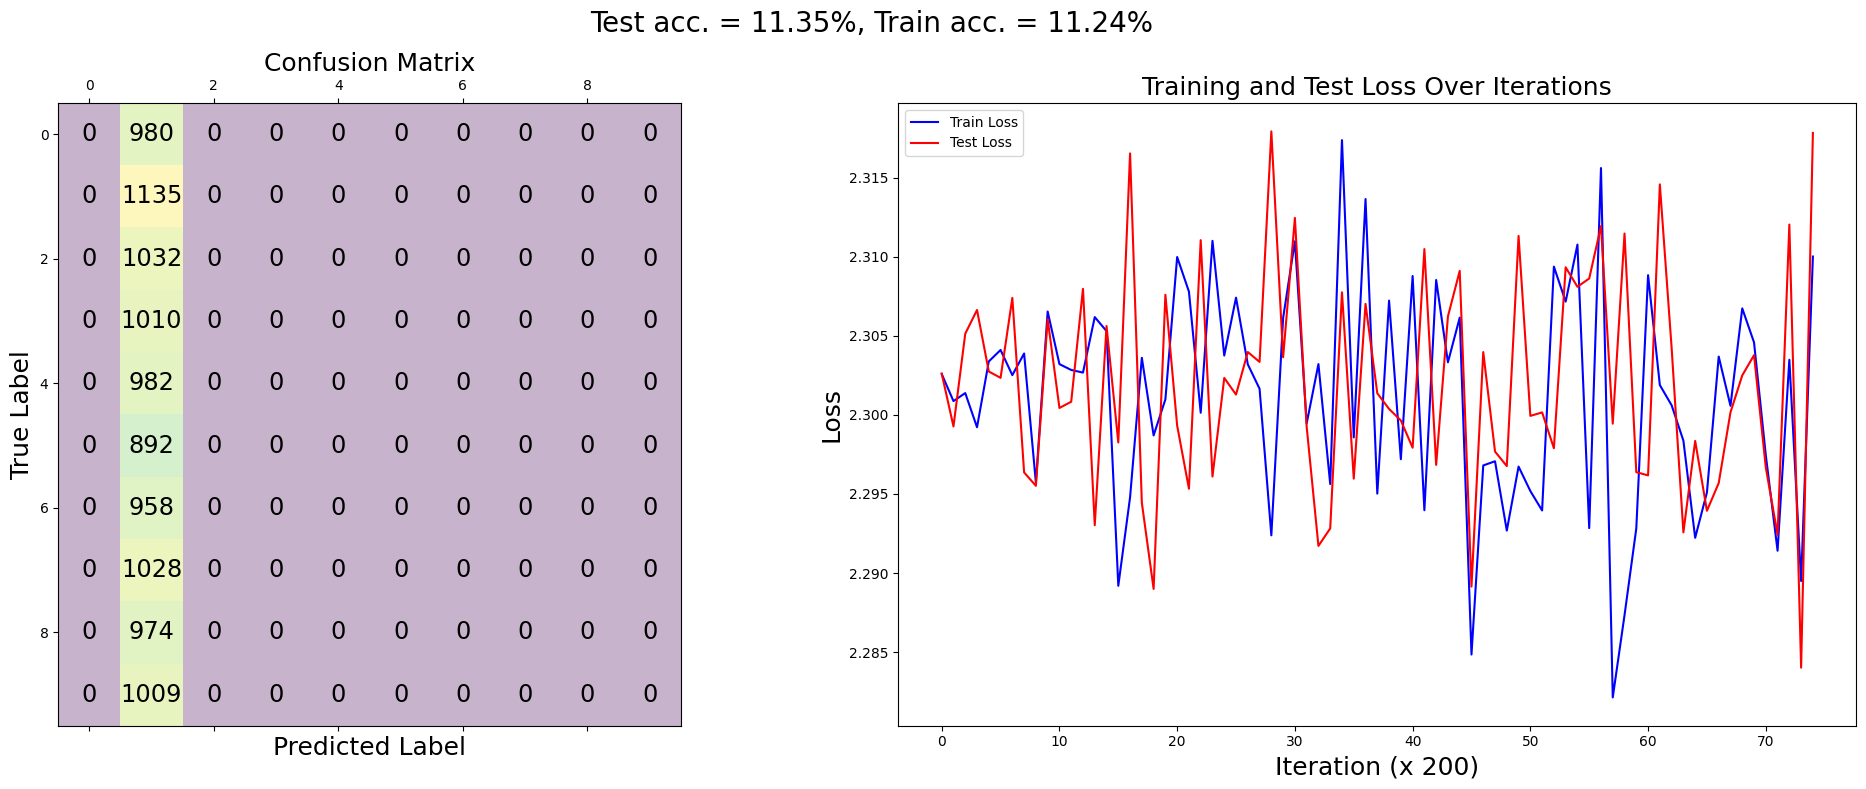

In [68]:
# Dictionary to store learned parameters for different models
learned_parameters = {}

learning_rate = 0.01
lambd = 0
epoch = 15
batch_size = 64
initial = "zero"
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Create a model name (key) based on training parameters
model_name = f"Epoch={epoch},alpha={learning_rate},Regularization={lambd},Batch={batch_size},Initialization={initial}"
print("Model Key: " + model_name)

# Train the model and store the learned parameters
learned_parameters[model_name] = model(
    train_dataloader,
    test_data,
    batch_size=batch_size,
    learning_rate=learning_rate,
    epoch=epoch,
    print_cost=True,
    lambd=lambd,
    initial=initial
)

# Find the model with 'zero' initialization dynamically
model_key = [key for key in learned_parameters.keys() if "Initialization=zero" in key][0]

# Plotting the losses and confusion matrix for the 'zero' initialization model
plotting(learned_parameters[model_key], test_data, train_data, tanh)


In [ ]:
print("Available model keys:", learned_parameters.keys())

Model Key: Epoch=15,alpha=0.01,Regularization=0,Batch=64,Initialization=random
Cost after epoch 0, iteration 0: Train Cost: 2.299490621790012, Test Cost: 2.249361357131885
Cost after epoch 0, iteration 200: Train Cost: 0.9619640599176462, Test Cost: 0.963802939966268
Cost after epoch 0, iteration 400: Train Cost: 0.7531023651961821, Test Cost: 0.631168952783942
Cost after epoch 0, iteration 600: Train Cost: 0.5872091773964412, Test Cost: 0.4597131639715725
Cost after epoch 0, iteration 800: Train Cost: 0.46487822468113765, Test Cost: 0.4142676025264681
Cost after epoch 1, iteration 0: Train Cost: 0.4799072757315818, Test Cost: 0.3672176341710244
Cost after epoch 1, iteration 200: Train Cost: 0.3600640954258434, Test Cost: 0.3518914588639778
Cost after epoch 1, iteration 400: Train Cost: 0.5171792036145257, Test Cost: 0.29038572098283294
Cost after epoch 1, iteration 600: Train Cost: 0.4895562544127641, Test Cost: 0.31786042401745185
Cost after epoch 1, iteration 800: Train Cost: 0.3784

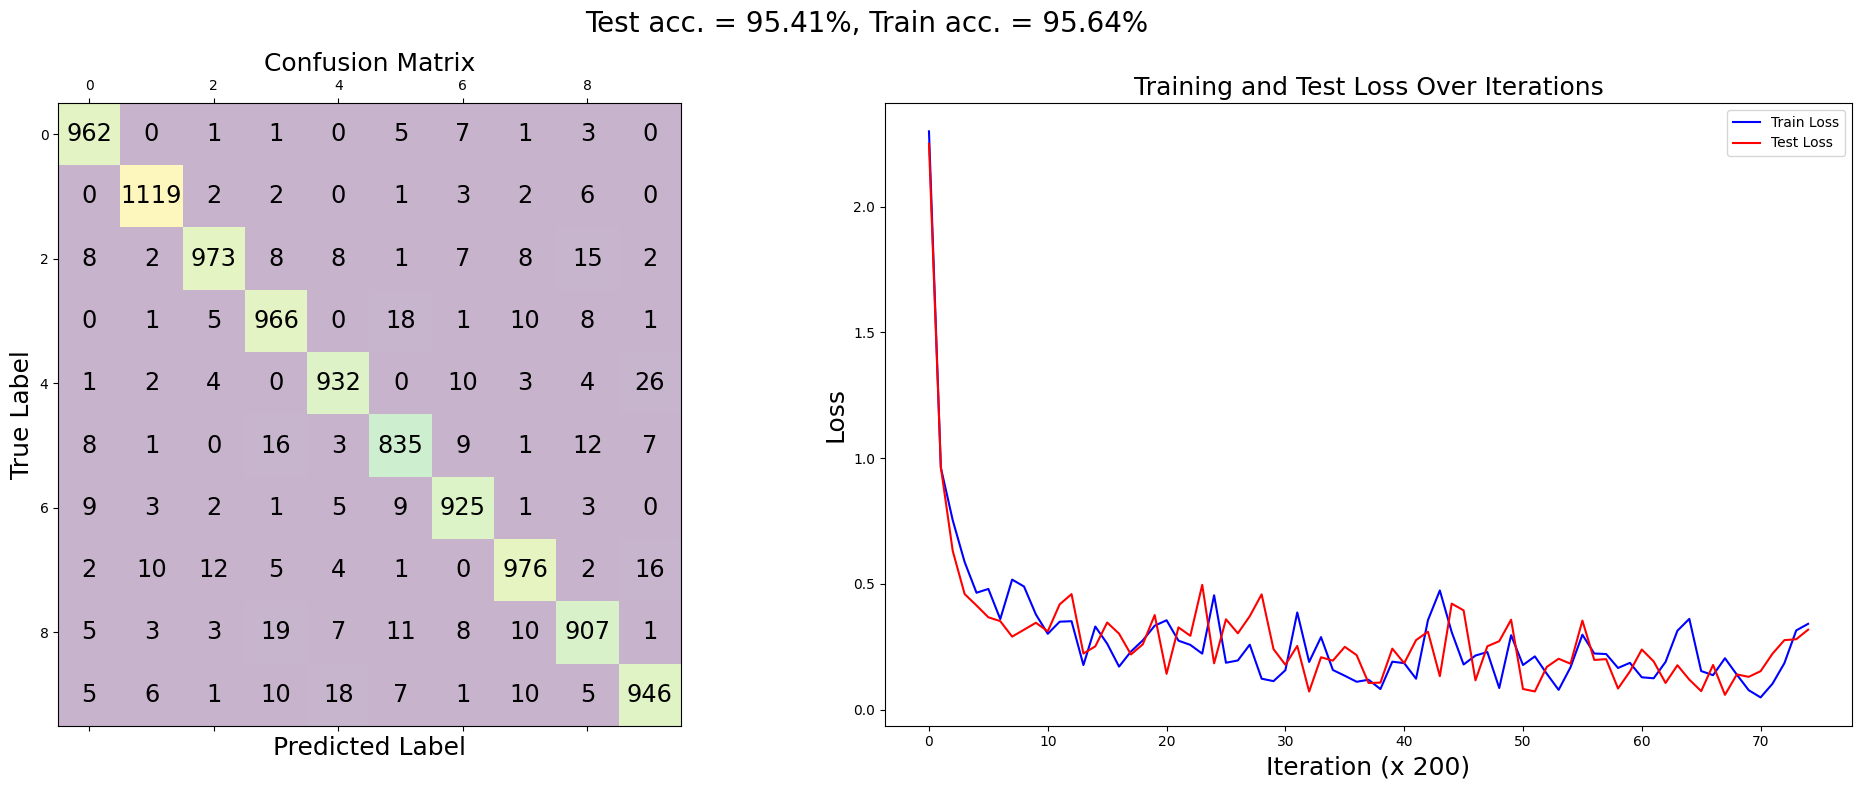

In [69]:
# Dictionary to store learned parameters for different models
learned_parameters = {}

learning_rate = 0.01
lambd = 0
epoch = 15
batch_size = 64
initial = "random"
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Create a model name (key) based on training parameters
model_name = f"Epoch={epoch},alpha={learning_rate},Regularization={lambd},Batch={batch_size},Initialization={initial}"
print("Model Key: " + model_name)

# Train the model and store the learned parameters
learned_parameters[model_name] = model(
    train_dataloader,
    test_data,
    batch_size=batch_size,
    learning_rate=learning_rate,
    epoch=epoch,
    print_cost=True,
    lambd=lambd,
    initial=initial
)

# Find the model with 'zero' initialization dynamically
model_key = [key for key in learned_parameters.keys() if "Initialization=random" in key][0]

# Plotting the losses and confusion matrix for the 'zero' initialization model
plotting(learned_parameters[model_key], test_data, train_data, tanh)


Model Key: Epoch=15,alpha=0.01,Regularization=0,Batch=64,Initialization=glorot
Cost after epoch 0, iteration 0: Train Cost: 2.402181451199647, Test Cost: 2.3645243826247904
Cost after epoch 0, iteration 200: Train Cost: 0.7597189753021367, Test Cost: 0.5572789436109884
Cost after epoch 0, iteration 400: Train Cost: 0.5009029235565605, Test Cost: 0.6109102424467863
Cost after epoch 0, iteration 600: Train Cost: 0.427422233175055, Test Cost: 0.48549954100404563
Cost after epoch 0, iteration 800: Train Cost: 0.38994489518285935, Test Cost: 0.44814707390401853
Cost after epoch 1, iteration 0: Train Cost: 0.4826853395253341, Test Cost: 0.33704153122526076
Cost after epoch 1, iteration 200: Train Cost: 0.44253956101279707, Test Cost: 0.14304370551590784
Cost after epoch 1, iteration 400: Train Cost: 0.2425591228097011, Test Cost: 0.4103089967750817
Cost after epoch 1, iteration 600: Train Cost: 0.2964783136875335, Test Cost: 0.26415471638625
Cost after epoch 1, iteration 800: Train Cost: 0.4

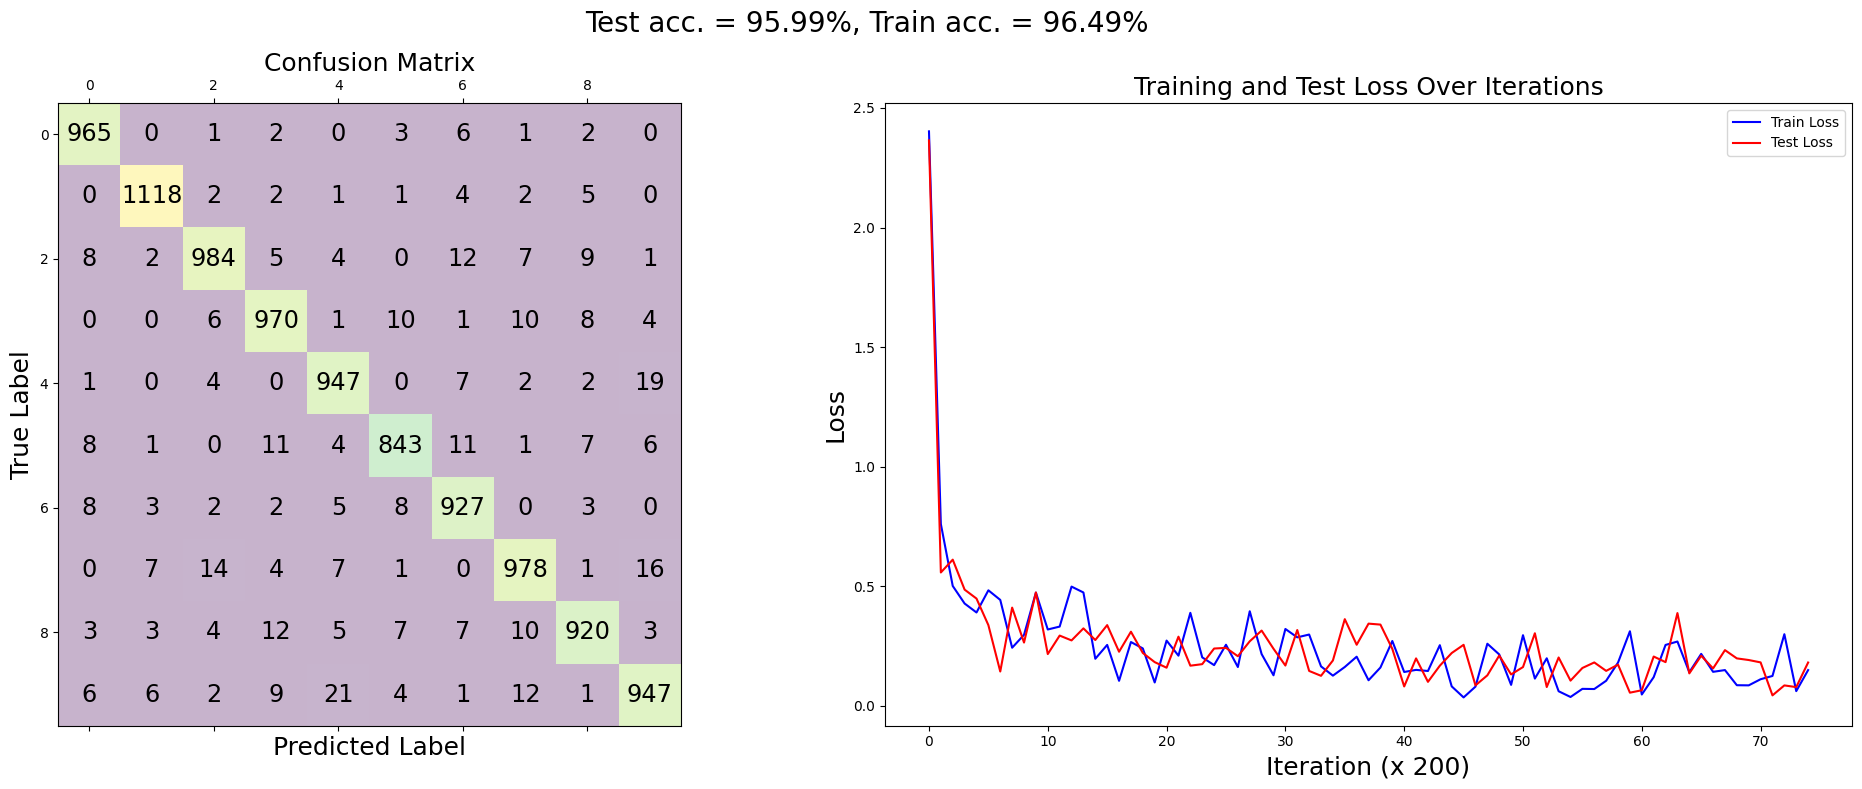

In [70]:
# Dictionary to store learned parameters for different models
learned_parameters = {}

learning_rate = 0.01
lambd = 0
epoch = 15
batch_size = 64
initial = "glorot"
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Create a model name (key) based on training parameters
model_name = f"Epoch={epoch},alpha={learning_rate},Regularization={lambd},Batch={batch_size},Initialization={initial}"
print("Model Key: " + model_name)

# Train the model and store the learned parameters
learned_parameters[model_name] = model(
    train_dataloader,
    test_data,
    batch_size=batch_size,
    learning_rate=learning_rate,
    epoch=epoch,
    print_cost=True,
    lambd=lambd,
    initial=initial
)

# Find the model with 'zero' initialization dynamically
model_key = [key for key in learned_parameters.keys() if "Initialization=glorot" in key][0]

# Plotting the losses and confusion matrix for the 'zero' initialization model
plotting(learned_parameters[model_key], test_data, train_data, tanh)
